<a href="https://colab.research.google.com/github/Dewak20/Data-Science-Project-Image-Classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import time
import shutil
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Deklarasi path untuk setiap kelas
path_data = '/content/drive/MyDrive/Classroom/Dataset'
path_incorrect_mask = os.path.join(path_data, 'mask_weared_incorrect')
path_with_mask = os.path.join(path_data, 'with_mask')
path_without_mask = os.path.join(path_data, 'without_mask')


In [3]:
#menyimpan list nama file data
train_incorrect_fnames = os.listdir(path_incorrect_mask)
train_mask_fnames = os.listdir(path_with_mask)
train_nomask_fnames = os.listdir(path_without_mask)

print(train_incorrect_fnames[:5])
print(train_mask_fnames[:5])
print(train_nomask_fnames[:5])

['2792.png', '2709.png', '2680.png', '2787.png', '2692.png']
['2296.png', '1927.png', '253.png', '2113.png', '256.png']
['201.png', '2278.png', '2513.png', '2385.png', '2617.png']


In [4]:
print('total Incorrect Mask :', len(os.listdir(path_incorrect_mask)))
print('total gambar with Mask :', len(os.listdir(path_with_mask)))
print('total gambar without Mask :', len(os.listdir(path_without_mask)))

total Incorrect Mask : 2994
total gambar with Mask : 2994
total gambar without Mask : 2994


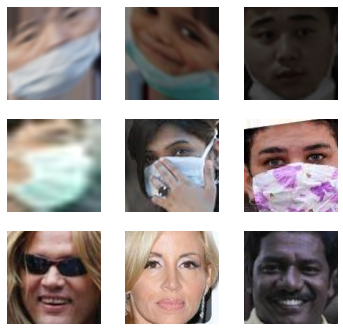

In [5]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 3

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

pic_index+=3

next_incorrect_pix = [os.path.join(path_incorrect_mask, fname) 
                for fname in train_incorrect_fnames[ pic_index-3:pic_index] 
               ]

next_mask_pix = [os.path.join(path_with_mask, fname) 
                for fname in train_mask_fnames[ pic_index-3:pic_index]
               ]

next_nomask_pix = [os.path.join(path_without_mask, fname) 
                for fname in train_nomask_fnames[ pic_index-3:pic_index]
               ]

for i, img_path in enumerate(next_incorrect_pix+next_mask_pix+next_nomask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [6]:
#Persiapan sebelum splitting data
#Membuat folder untuk train dan validasi setiap kelas

path_data_baru = './Dataset'
os.mkdir(path_data_baru)

train_dir = os.path.join(path_data_baru,'train')
test_dir = os.path.join(path_data_baru,'val')

incorrect_train = os.path.join(train_dir,'incorrect')
incorrect_test = os.path.join(test_dir,'incorrect')

mask_train = os.path.join(train_dir,'mask')
mask_test = os.path.join(test_dir,'mask')

nomask_train = os.path.join(train_dir,'nomask')
nomask_test = os.path.join(test_dir,'nomask')

list_dir = [train_dir,test_dir,incorrect_train,incorrect_test,
            mask_train,mask_test,nomask_train,nomask_test]

for i in list_dir:
  os.mkdir(i)

In [7]:
#Data splitting dengan validation set = 10% total data
from sklearn.model_selection import train_test_split

train_incorrect_dir, test_incorrect_dir = train_test_split(os.listdir(path_incorrect_mask), test_size = 0.10)
train_mask_dir, test_mask_dir = train_test_split(os.listdir(path_with_mask), test_size = 0.10)
train_nomask_dir, test_nomask_dir = train_test_split(os.listdir(path_without_mask), test_size = 0.10)

In [8]:
train_incorrect_dir[:2]

['817.png', '717.png']

In [9]:
#Memindahkan hasil split ke folder yang telah dibuat
for i in train_incorrect_dir:
  shutil.copy(os.path.join(path_incorrect_mask,i), os.path.join(incorrect_train,i))
for i in test_incorrect_dir:
  shutil.copy(os.path.join(path_incorrect_mask,i), os.path.join(incorrect_test,i))

for i in train_mask_dir:
  shutil.copy(os.path.join(path_with_mask,i), os.path.join(mask_train,i))
for i in test_mask_dir:
  shutil.copy(os.path.join(path_with_mask,i), os.path.join(mask_test,i))

for i in train_nomask_dir:
  shutil.copy(os.path.join(path_without_mask,i), os.path.join(nomask_train,i))
for i in test_nomask_dir:
  shutil.copy(os.path.join(path_without_mask,i), os.path.join(nomask_test,i))

# **Image Augmentation**

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size =(150,150),
    batch_size = 32,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical')

Found 8082 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [12]:
#Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

model = Sequential()

#Konvolusi 1 + Input Layer 1
model.add(Conv2D(16, (3,3), activation='relu',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2,2))
#Konvolusi 2
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
#Konvolusi 3
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
#Konvolusi 4
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
#Flatten
model.add(Flatten())
#Hidden Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#Hidden Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#Output Layer
model.add(Dense(3, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [14]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [15]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
      self.model.stop_training = True

stopTraining = Callback()

In [16]:
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=1000,
                    callbacks=[stopTraining])

Epoch 1/1000
253/253 [==============================] - 194s 762ms/step - loss: 0.4681 - accuracy: 0.8097 - val_loss: 0.2515 - val_accuracy: 0.8933
Epoch 2/1000
253/253 [==============================] - 191s 755ms/step - loss: 0.2655 - accuracy: 0.9025 - val_loss: 0.1837 - val_accuracy: 0.9267
Epoch 3/1000
253/253 [==============================] - 193s 763ms/step - loss: 0.1852 - accuracy: 0.9321 - val_loss: 0.1095 - val_accuracy: 0.9622
Epoch 4/1000
253/253 [==============================] - 191s 754ms/step - loss: 0.1537 - accuracy: 0.9462 - val_loss: 0.1511 - val_accuracy: 0.9444
Epoch 5/1000
253/253 [==============================] - 190s 752ms/step - loss: 0.1333 - accuracy: 0.9532 - val_loss: 0.0987 - val_accuracy: 0.9578


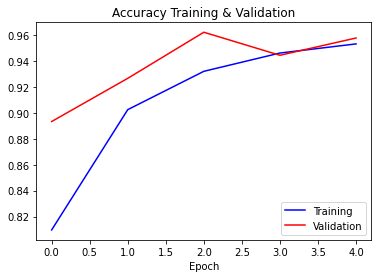

In [17]:
plt.plot(history.history['accuracy'], label='Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation', color='red')
plt.title('Accuracy Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

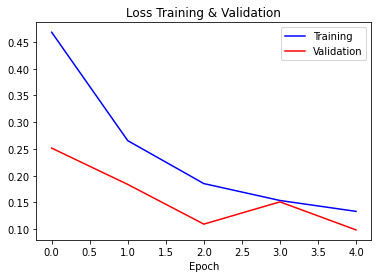

In [18]:
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='red')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [19]:
def predict(image_upload):
  for fn in image_upload.keys():
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
 
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
  
    print(fn)
    if classes[0,0] != 0:
      print('Incorrect_Mask')
    elif classes[0,1] != 0:
      print('With_Mask')
    else:
      print('Without_Mask')

Saving istockphoto-1178963112-170667a.jpg to istockphoto-1178963112-170667a.jpg
istockphoto-1178963112-170667a.jpg
With_Mask


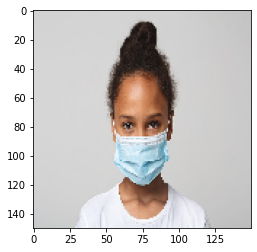

In [20]:
image_test = files.upload()
predict(image_test)